In [7]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import spacy # tokenization, lammatization, removing stop words & punctuations

import nltk
from nltk.corpus import stopwords
from  nltk.stem import PorterStemmer


from nltk.tokenize import TweetTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Dense, Dropout, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import tensorflow as tf
import ktrain
from ktrain import text
sns.set()
nlp = spacy.load("en_core_web_sm",disable=["tagger", "parser", "ner"])

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_len = len(train)
test_len = len(test)
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [9]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

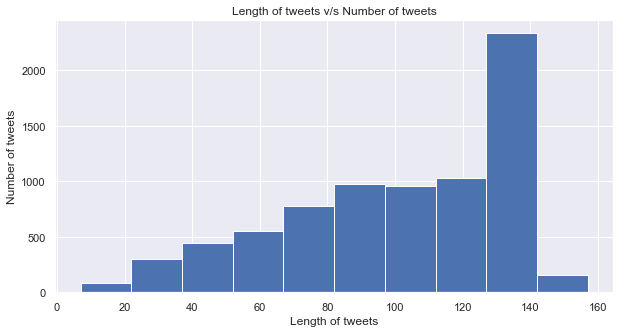

In [10]:
plt.figure(figsize=(10,5))
word_len = train['text'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Length of tweets')
plt.ylabel('Number of tweets')
plt.title('Length of tweets v/s Number of tweets')
plt.show()

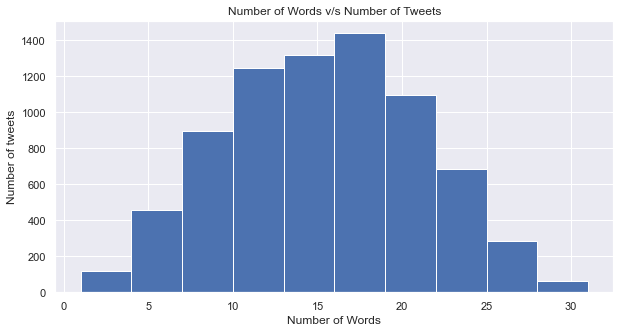

In [11]:
plt.figure(figsize=(10,5))
word_len = train['text'].str.split().map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of Words')
plt.ylabel('Number of tweets')
plt.title('Number of Words v/s Number of Tweets')
plt.show()

In [12]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
train['keyword'].fillna('',inplace=True)
train['text'] = train['text'] + ' ' + train['keyword']
train['text'] = train['text'].apply(lambda x: x.strip())
train.drop(['keyword'],axis=1,inplace=True)
train.drop(['location'],axis=1,inplace=True)
train.head()


id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

In [14]:
test['keyword'].fillna('',inplace=True)
test['text'] = test['text'] + ' ' + test['keyword']
test['text'] = test['text'].apply(lambda x: x.strip())
test.drop(['keyword'],axis=1,inplace=True)
test.drop(['location'],axis=1,inplace=True)
test.head()

id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan

In [15]:
duplicate_records = train[train.duplicated(['text','target'],keep=False)] # Duplicate records with same targets.
print('Records having same text and targets:',len(duplicate_records))
duplicate_records.head()

Records having same text and targets: 117


id                                               text  target
40    59  Check these out: http://t.co/rOI2NSmEJJ http:/...       0
48    68  Check these out: http://t.co/rOI2NSmEJJ http:/...       0
106  156  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
115  165  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
118  171  320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0

In [16]:
train.drop_duplicates(['text','target'],inplace=True) # Dropping the duplicate records having same targets.

In [17]:
contradicting_records = train[train.duplicated(['text'],keep=False)] # Duplicate records with outliers.
print('Records having same text but different targets:',len(contradicting_records))
contradicting_records.head()

Records having same text but different targets: 30


id                                               text  target
610    881            To fight bioterrorism sir. bioterrorism       1
624    898            To fight bioterrorism sir. bioterrorism       0
2830  4068  .POTUS #StrategicPatience is a strategy for #G...       1
2832  4076  .POTUS #StrategicPatience is a strategy for #G...       0
3240  4656  He came to a land which was engulfed in tribal...       0

In [18]:
records_to_drop = [610,2832,3243,3985,4244,4232,4292,4305,4306,4312,4320,4381,4618,5620,6091,6616] # Outliers.

train.drop(records_to_drop,inplace=True) # Dropping the outliers.
train = train.reset_index(drop=True) # Resetting the indexes.
train.head()

id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

In [19]:
stop_words = stopwords.words("english")
stemmer = PorterStemmer()

pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

train['text']=train['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_html(x))
train.head()

id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

In [14]:
def clean(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    
    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    
    text = re.sub('[^a-zA-Z]', ' ', tweet)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

train['text'] = train['text'].apply(clean)
test['text'] =test['text'].apply(clean)
train.head()

id                                               text  target
0   1       deeds reason earthquake may allah forgive us       1
1   4              forest fire near la ronge sask canada       1
2   5  residents asked shelter place notified officer...       1
3   6  people receive wildfires evacuation orders cal...       1
4   7  got sent photo ruby alaska smoke wildfires pou...       1

In [15]:
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['target'],axis=1,inplace=True)
data.head()

id                                               text
0   1       deeds reason earthquake may allah forgive us
1   4              forest fire near la ronge sask canada
2   5  residents asked shelter place notified officer...
3   6  people receive wildfires evacuation orders cal...
4   7  got sent photo ruby alaska smoke wildfires pou...

In [16]:
tt = TweetTokenizer()
data['tokens'] = data['text'].apply(lambda x: tt.tokenize(x))
data.head()

id                                               text  \
0   1       deeds reason earthquake may allah forgive us   
1   4              forest fire near la ronge sask canada   
2   5  residents asked shelter place notified officer...   
3   6  people receive wildfires evacuation orders cal...   
4   7  got sent photo ruby alaska smoke wildfires pou...   

                                              tokens  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [people, receive, wildfires, evacuation, order...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...

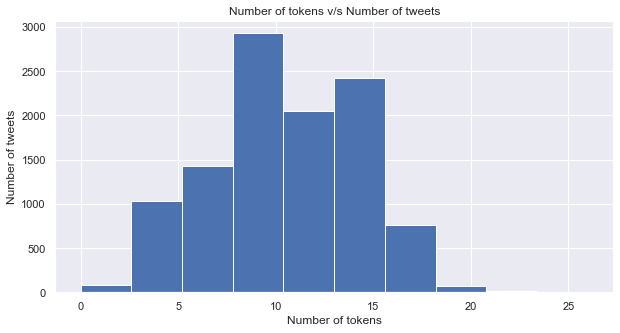

In [17]:
plt.figure(figsize=(10,5))
word_len = data['tokens'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of tokens')
plt.ylabel('Number of tweets')
plt.title('Number of tokens v/s Number of tweets')
plt.show()

In [18]:
glove_vec_file = open('glove.6B.300d.txt')
embeddings = {}
for line in glove_vec_file:
    values = line.split()
    word = values[0]
    embedding = np.array(values[1:])
    embeddings[word] = embedding
glove_vec_file.close()

In [19]:
embeddings

{'the': array(['0.04656', '0.21318', '-0.0074364', '-0.45854', '-0.035639',
        '0.23643', '-0.28836', '0.21521', '-0.13486', '-1.6413',
        '-0.26091', '0.032434', '0.056621', '-0.043296', '-0.021672',
        '0.22476', '-0.075129', '-0.067018', '-0.14247', '0.038825',
        '-0.18951', '0.29977', '0.39305', '0.17887', '-0.17343',
        '-0.21178', '0.23617', '-0.063681', '-0.42318', '-0.11661',
        '0.093754', '0.17296', '-0.33073', '0.49112', '-0.68995',
        '-0.092462', '0.24742', '-0.17991', '0.097908', '0.083118',
        '0.15299', '-0.27276', '-0.038934', '0.54453', '0.53737',
        '0.29105', '-0.0073514', '0.04788', '-0.4076', '-0.026759',
        '0.17919', '0.010977', '-0.10963', '-0.26395', '0.07399',
        '0.26236', '-0.1508', '0.34623', '0.25758', '0.11971', '-0.037135',
        '-0.071593', '0.43898', '-0.040764', '0.016425', '-0.4464',
        '0.17197', '0.046246', '0.058639', '0.041499', '0.53948',
        '0.52495', '0.11361', '-0.048315', 

In [20]:
def embeddings_out(data, maxlen=20):
    output = np.zeros((data.shape[0],20,300))
    for ix in range(len(data)):
        curr_len = min(maxlen, maxlen,len(data.iloc[ix]['tokens']))
        for jx in range(curr_len):
            word = str(data.iloc[ix]['tokens'][jx])
            if word in embeddings:
                output[ix][jx] = embeddings[data.iloc[ix]['tokens'][jx]]
    return output

In [21]:
X = embeddings_out(data)
X.shape

(10788, 20, 300)

In [22]:
X_train = X[:len(train)]
X_test = X[len(train):]
y_train = train['target'].values
len(X_train), len(X_test), len(y_train)

(7525, 3263, 7525)

## Model Creation

In [23]:
def create_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dropout(0.1))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Activation('softmax'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [24]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 64)            93440     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [25]:
#I would be using early stopping callback and would use 1/10th of the training data as validation to estimate the optimum number of epochs taht would prvent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
hist = model.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=True, validation_split=0.1, callbacks=[early_stop])

Epoch 1/100
106/106 [==============================] - 9s 42ms/step - loss: 0.6681 - accuracy: 0.6463 - val_loss: 0.5960 - val_accuracy: 0.7888
Epoch 2/100
106/106 [==============================] - 3s 28ms/step - loss: 0.5861 - accuracy: 0.7891 - val_loss: 0.5671 - val_accuracy: 0.7995
Epoch 3/100
106/106 [==============================] - 3s 30ms/step - loss: 0.5556 - accuracy: 0.8070 - val_loss: 0.5477 - val_accuracy: 0.7968
Epoch 4/100
106/106 [==============================] - 3s 30ms/step - loss: 0.5319 - accuracy: 0.8141 - val_loss: 0.5316 - val_accuracy: 0.8127
Epoch 5/100
106/106 [==============================] - 3s 30ms/step - loss: 0.5099 - accuracy: 0.8220 - val_loss: 0.5233 - val_accuracy: 0.8061
Epoch 6/100
106/106 [==============================] - 3s 29ms/step - loss: 0.4834 - accuracy: 0.8449 - val_loss: 0.5101 - val_accuracy: 0.8035
Epoch 7/100
106/106 [==============================] - 3s 32ms/step - loss: 0.4693 - accuracy: 0.8448 - val_loss: 0.5099 - val_accuracy:

<AxesSubplot:>

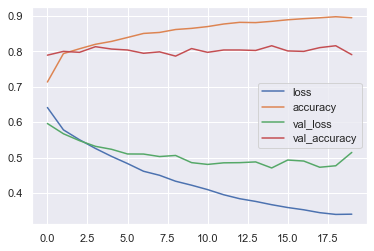

In [26]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [27]:
model = create_model()

In [28]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, shuffle=True)

Epoch 1/20
118/118 [==============================] - 7s 28ms/step - loss: 0.6703 - accuracy: 0.6325
Epoch 2/20
118/118 [==============================] - 3s 27ms/step - loss: 0.6244 - accuracy: 0.7082
Epoch 3/20
118/118 [==============================] - 3s 29ms/step - loss: 0.5791 - accuracy: 0.7840
Epoch 4/20
118/118 [==============================] - 3s 28ms/step - loss: 0.5627 - accuracy: 0.7871
Epoch 5/20
118/118 [==============================] - 3s 27ms/step - loss: 0.5426 - accuracy: 0.7940
Epoch 6/20
118/118 [==============================] - 3s 29ms/step - loss: 0.5125 - accuracy: 0.8145
Epoch 7/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4814 - accuracy: 0.8331
Epoch 8/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4674 - accuracy: 0.8384
Epoch 9/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4708 - accuracy: 0.8238
Epoch 10/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4509 - accura

<AxesSubplot:>

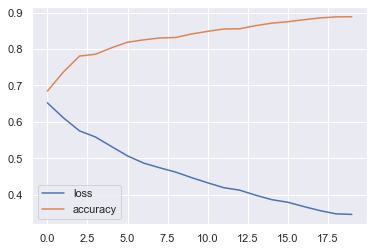

In [29]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [30]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

In [31]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = pred
result.head()

id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1

In [32]:
result.to_csv('/Users/orucberatturan/Desktop/submission_LSTM.csv',index=False)

### BERT

In [20]:
train_data = train.head(7000).copy()
val_data = train.tail(525).copy()

In [21]:
train_data.head()

id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

In [22]:
(X_train, y_train), (X_val, y_val), preproc = text.texts_from_df(train_df=train_data,
text_column = 'text',label_columns = 'target',val_df = val_data,maxlen = 32,preprocess_mode = 'bert')

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


### Model Creation

In [23]:
model = text.text_classifier(name = 'bert', train_data = (X_train, y_train), preproc= preproc)

Is Multi-Label? False
maxlen is 32
done.


In [24]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_val, y_val), batch_size=16)

### Model Training

In [25]:
learner.fit_onecycle(lr = 2e-5, epochs = 2)
predictor = ktrain.get_predictor(learner.model, preproc)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
438/438 [==============================] - 981s 2s/step - loss: 0.5600 - accuracy: 0.7294 - val_loss: 0.3918 - val_accuracy: 0.8286
Epoch 2/2
438/438 [==============================] - 975s 2s/step - loss: 0.3404 - accuracy: 0.8614 - val_loss: 0.3740 - val_accuracy: 0.8400


In [26]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = predictor.predict(test['text'].values)
result['target'] = result['target'].map(lambda x:1 if x=='target' else 0)
result.head()

id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1

In [27]:
result.to_csv('submission_bert.csv', index=False)